In [2]:
import os 
import cv2

from PIL import Image
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms

import matplotlib.pyplot as plt

from scipy.interpolate import LinearNDInterpolator

In [294]:
def load_gt_disp_kitti(path):
    """
    Loads in the ground truth files from the KITTI Stereo Dataset

    Args:
        -path (string): path to the the training files

    Returns:
        -gt_disparities (list): list of ground truth disparities
    """
    gt_disparities = []
    for i in range(200):
        disp = cv2.imread(
                path + "/training/disp_noc_0/" + str(i).zfill(6) + "_10.png", -1
        )
        disp = disp.astype(np.float32) / 256
        gt_disparities.append(disp)
    return gt_disparities

def load_kitti_image(path,index,resize = True, asTensor = False):
    """
    Loads in the images from the KITTI Stereo Dataset

    Args:
        -path (string): path to the the training files
        -resize (string): left or right camera 

    Returns:
        -images (list): list of images
    """
    size = (256, 512)
    
    left_image = Image.open(path + "/training/image_2/" + str(index).zfill(6) + "_10.png")
    right_image = Image.open(path + "/training/image_3/" + str(index).zfill(6) + "_10.png")
    
    if resize:
        resize = transforms.Resize(size)
        left_image = resize(left_image)
        right_image = resize(right_image)
        
        
    if asTensor:
        toTensor = transforms.ToTensor()
        left_image = toTensor(left_image)
        right_image = toTensor(right_image)

    return left_image, right_image 
    

def load_pred_disp(path, resize = False):
    """ 
     
    """
    disp = np.load(path)
    height, width = (375, 1242)
    
    if resize:
        resized_disp = []
        for i in range(disp.shape[0]):
            resized_disp.append(width * cv2.resize(disp[i], (width, height), interpolation=cv2.INTER_LINEAR))
        disp = resized_disp 
        
    return disp 

def sigmoid(x):
   return 1 / (1 + np.exp(x))

def lin_interp(image):
    """ Linearly interpolates the depth data to fill zero holes - adapted from https://github.com/hunse/kitti

    Args:
        -shape(tuple): size of the image
        -xyd (np array):

    Returns:
        -points (2D): points
    """

    shape = image.shape
    m, n = shape
    ij = np.matrix(np.nonzero(image)).T
    d = image[np.nonzero(image)]

    f = LinearNDInterpolator(ij, d, fill_value=0)
    J, I = np.meshgrid(np.arange(n), np.arange(m))
    IJ = np.vstack([I.flatten(), J.flatten()]).T
    disparity_interpolated = f(IJ).reshape(shape)

    return disparity_interpolated

def plot_disparity_map(disp): 
    ymax, xmax = disp.shape
    dpi = ymax
    fig = plt.figure(figsize=(8, 4), frameon=False)
    ax = plt.Axes(fig, [0, 0, 1, 1])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(disp, aspect="auto", cmap="plasma")
    plt.show()

def convert_disps_to_depths_kitti(gt_disparities, pred_disparities):
        """
        Converts the ground truth disparities from the KITTI Stereo dataset and the predictions to depth values

        Args:
         -gt_disparities (list): ground truth disparities
         -pred_disparities (list): predicted disparities

        Returns:
         -gt_depths (list): list of ground truth depths
         -pred_depths (list): list of predicted depths
         -pred_depths_resized (list): list of predicted depths, resized to ground truth disparity size

        """
        gt_depths = []
        pred_depths = []
        pred_disparities_resized = []

        
        width_to_focal = dict()
        width_to_focal[1242] = 721.5377
        width_to_focal[1241] = 718.856
        width_to_focal[1224] = 707.0493
        width_to_focal[1238] = 718.3351
        
        
        for i in range(len(gt_disparities)):
            gt_disp = gt_disparities[i]
            height, width = gt_disp.shape

            pred_disp = pred_disparities[i]
            pred_disp = width * cv2.resize(
                pred_disp, (width, height), interpolation=cv2.INTER_LINEAR
            )

            pred_disparities_resized.append(pred_disp)

            mask = gt_disp > 0

            gt_depth = width_to_focal[width] * 0.54 / (gt_disp + (1.0 - mask))
            pred_depth = width_to_focal[width] * 0.54 / pred_disp

            gt_depths.append(gt_depth)
            pred_depths.append(pred_depth)

        return gt_depths, pred_depths, pred_disparities_resized
    
    
def apply_disparity(img, disp):
        """ Applies a disparity map to an image.

        Args:
            img: (n_batch, n_dim, nx, ny) input image
            disp: (n_batch, 1, nx, ny) disparity map to be applied

        Returns:
            the input image shifted by the disparity map (n_batch, n_dim, nx, ny)
        """
        
        width,height = right_image.size
        img = transforms.ToTensor()(right_image).unsqueeze(0)
        disp = torch.tensor(disp)

        device = torch.device('cpu')
        
        # Original coordinates of pixels
        x_base = (
            torch.linspace(0, 1, width)
            .repeat(1,height, 1)
            .type_as(img)
            .to(device)
        )
        y_base = (
            torch.linspace(0, 1, height)
            .repeat(1,width, 1)
            .transpose(1, 2)
            .type_as(img)
        ).to(device)

        # Apply shift in X direction
        x_shifts = disp[:, :]  # Disparity is passed in NCHW format with 1 channel
        flow_field = torch.stack((x_base + x_shifts, y_base), dim=3)

        # In grid_sample coordinates are assumed to be between -1 and 1
        output = F.grid_sample(img, 2 * flow_field - 1, mode="bilinear", padding_mode="zeros")

        return output.squeeze()

In [4]:
#folder structure 
#have the images in data/kitti

#milestones folder 
os.listdir('data/output/milestones/aspp-modules/1/test/')

['disparities.npy', 'disparities_pp.npy', 'preds', 'scores.csv']

In [295]:
#loading disparity data and generating depth maps
kitti_gt_disp = load_gt_disp_kitti('data/kitti')
pred_disp = load_pred_disp('data/output/milestones/aspp-modules/1/test/disparities.npy')
pred_disp_resized = load_pred_disp('data/output/milestones/aspp-modules/1/test/disparities.npy',resize=True)
gt_depths, pred_depths, pred_depths_resized = convert_disps_to_depths_kitti(kitti_gt_disp,pred_disp)

#how to load single images (as PIL or Tensor) - set asTensor = true 
left_image, right_image   = load_kitti_images('data/kitti', index = i, resize=True)
left_tensor, right_tensor = load_kitti_image('data/kitti', index = i, resize=True, asTensor=True)

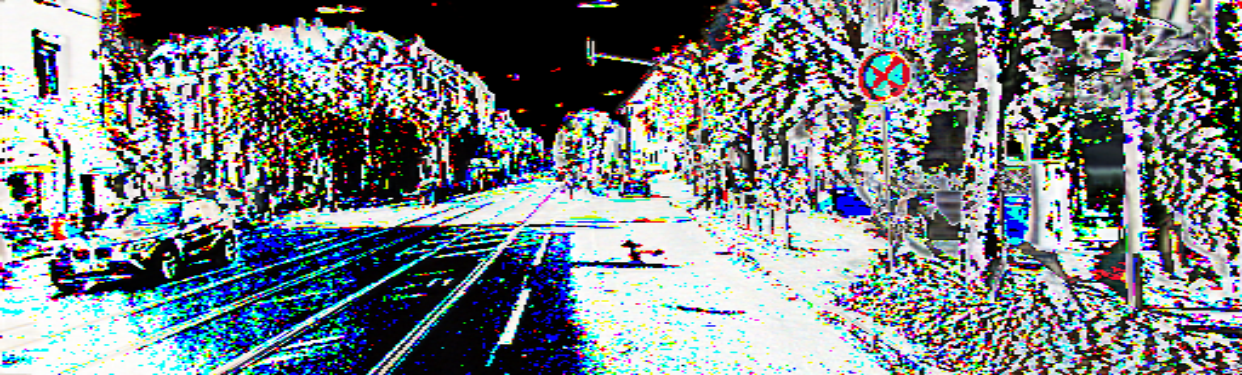

In [304]:
#reconstruction error plots

#get the images from dataset
i = 1 #image index
left_image, right_image   = load_kitti_image('data/kitti', index = i, resize=True)
left_tensor, right_tensor = load_kitti_image('data/kitti', index = i, resize=True, asTensor=True)

#apply the left disparity map to the right_image
output = apply_disparity(right_image, - pred_disp[i])

#resize and output image
final = transforms.ToPILImage()(output-left_tensor)
final = transforms.Resize(size=(375,1242))(final)
final

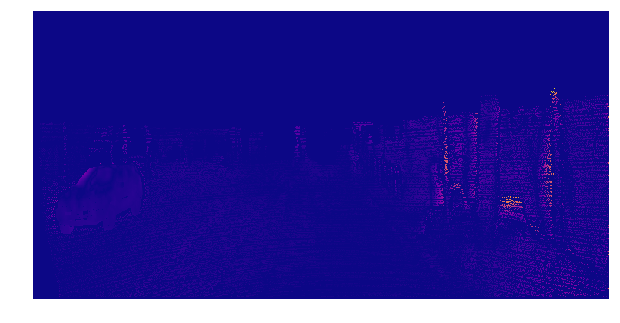

54.894234

In [303]:
#Difference Maps between ground truth and predicted disparities (masked at the available pixels)
i = 1 #image index
gt = kitti_gt_disp[i]
pred = pred_disp_resized[i]

toPILImage = transforms.ToPILImage()
toTensor = transforms.ToTensor()

mask = gt > 0
pred[np.logical_not(mask)] = 0

#plot_disparity_map(gt)
#plot_disparity_map(pred)

diff = np.abs(gt-pred)
plot_disparity_map(diff)

#TODO find appropiate way to visualize magnitude of error (in dense disparity map or in original image)

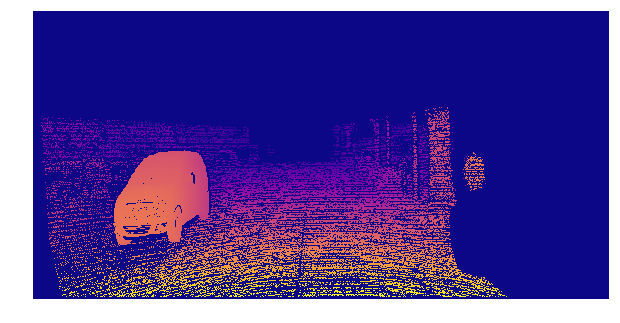

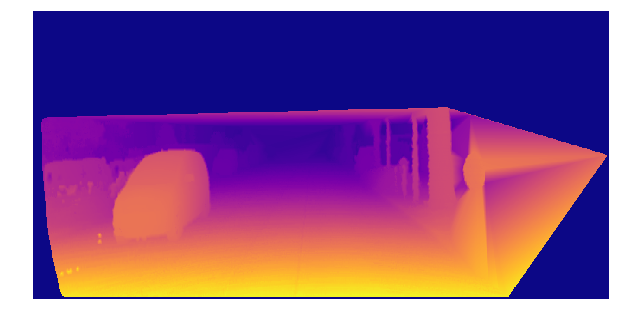

In [290]:
#interpolation of disparity maps 
gt_disp = kitti_gt_disp[0]

disparity_interpolated = lin_interp(image)
disparity_sparse = image

plot_disparity_map(disparity_sparse)
plot_disparity_map(disparity_interpolated)